# Separating solar surface features with Gaussian Mixture models

In [1]:
import numpy as np 

from matplotlib import pyplot as pl
from matplotlib import cm

from scipy import linalg
from sklearn import mixture

## 1. Load the data

In [4]:
input_data = "solar_surface_dataset_20170423.npz"


with np.load(input_data) as aa: 
    data_raw = aa["arr_0"]

data = data_raw + 0.0
for el in range(data.shape[1]):
    data[:, el] = data_raw[:, el] - np.mean(data_raw[:, el])
    data[:, el] = data_raw[:, el] / np.max(np.abs(data_raw[:, el]))

## 2. Preview of the data

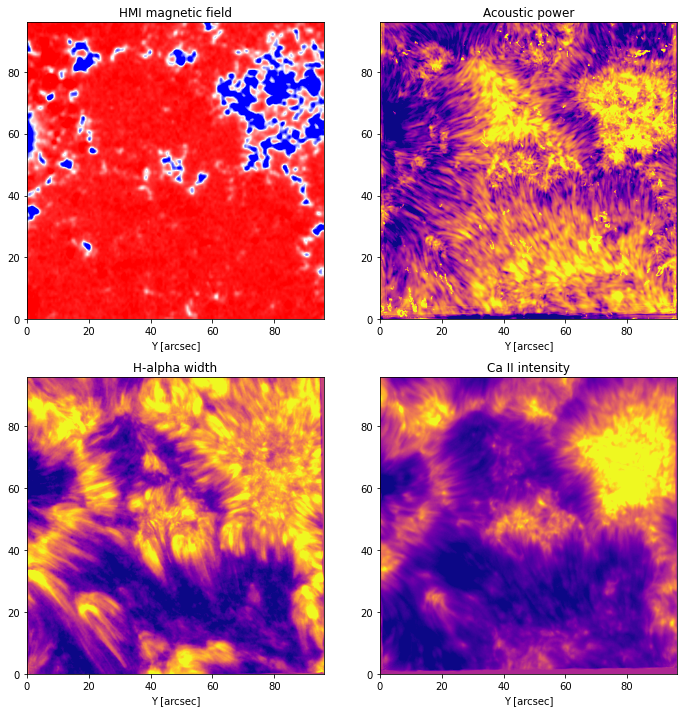

In [6]:
num_panels = 4 

fig, ax = pl.subplots(2, 2, figsize=(10, 10))

ax_flat = ax.flatten()

labels = ["HMI magnetic field", "Acoustic power", "H-alpha width", "Ca II intensity"]
extent = [0, 96, 0, 96]
cmaps = ["bwr", "plasma", "plasma", "plasma"]

for el in range(len(ax_flat)):
    ax_flat[el].imshow(data[:, el].reshape(1000, 1000), origin="lower", extent=extent,
                       vmin=np.quantile(data[:, el], 0.04),
                       vmax=np.quantile(data[:, el], 0.96),
                       cmap=cmaps[el])
    ax_flat[el].set_title(labels[el])
    ax_flat[el].set_xlabel("X [arcsec]")
    ax_flat[el].set_xlabel("Y [arcsec]")
    
pl.tight_layout() 

## 3. Compute GMMs with the expectation minimization algorithm and BIC optimization

In [10]:
n_components_range = range(2, 10)
cv_types = ["full"]

bic = []
lowest_bic = np.infty

for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = mixture.GaussianMixture(n_components=n_components, 
                                      covariance_type=cv_type)
        gmm.fit(data)
        bic.append(gmm.bic(data[::100, :]))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            
bic = np.array(bic)

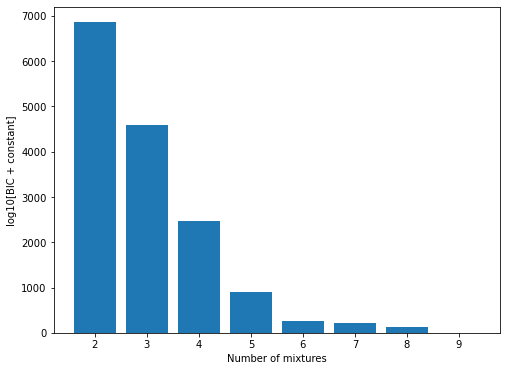

In [12]:
# plot the bic scores

pl.figure(figsize=(8, 6))
bic_a = bic -  np.amin(bic) + 1 #to make it positive
pl.bar(n_components_range, (bic_a))
pl.ylabel("log10[BIC + constant]")
pl.xlabel("Number of mixtures")
pl.show() 

## 4. Compute Variational (Bayesian) GMMS with a Dirichlet generative process

In [102]:
n_components = 7

dpgmm = mixture.BayesianGaussianMixture(n_components=n_components,
                                        weight_concentration_prior_type="dirichlet_distribution",
                                        weight_concentration_prior=.01,
                                        mean_precision_prior=0.8,
                                        max_iter=10000,
                                        reg_covar=0, init_params="random").fit(data[::50, 2:4])

#dpgmm = mixture.BayesianGaussianMixture(n_components=n_components,
#                                        covariance_type="full", max_iter=10000).fit(data[::50, 2:4])

<BarContainer object of 7 artists>

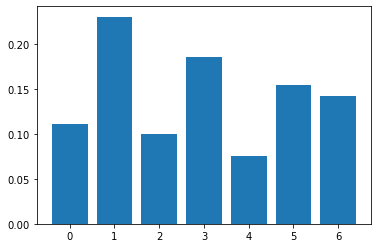

In [103]:
pl.bar(range(n_components), dpgmm.weights_)

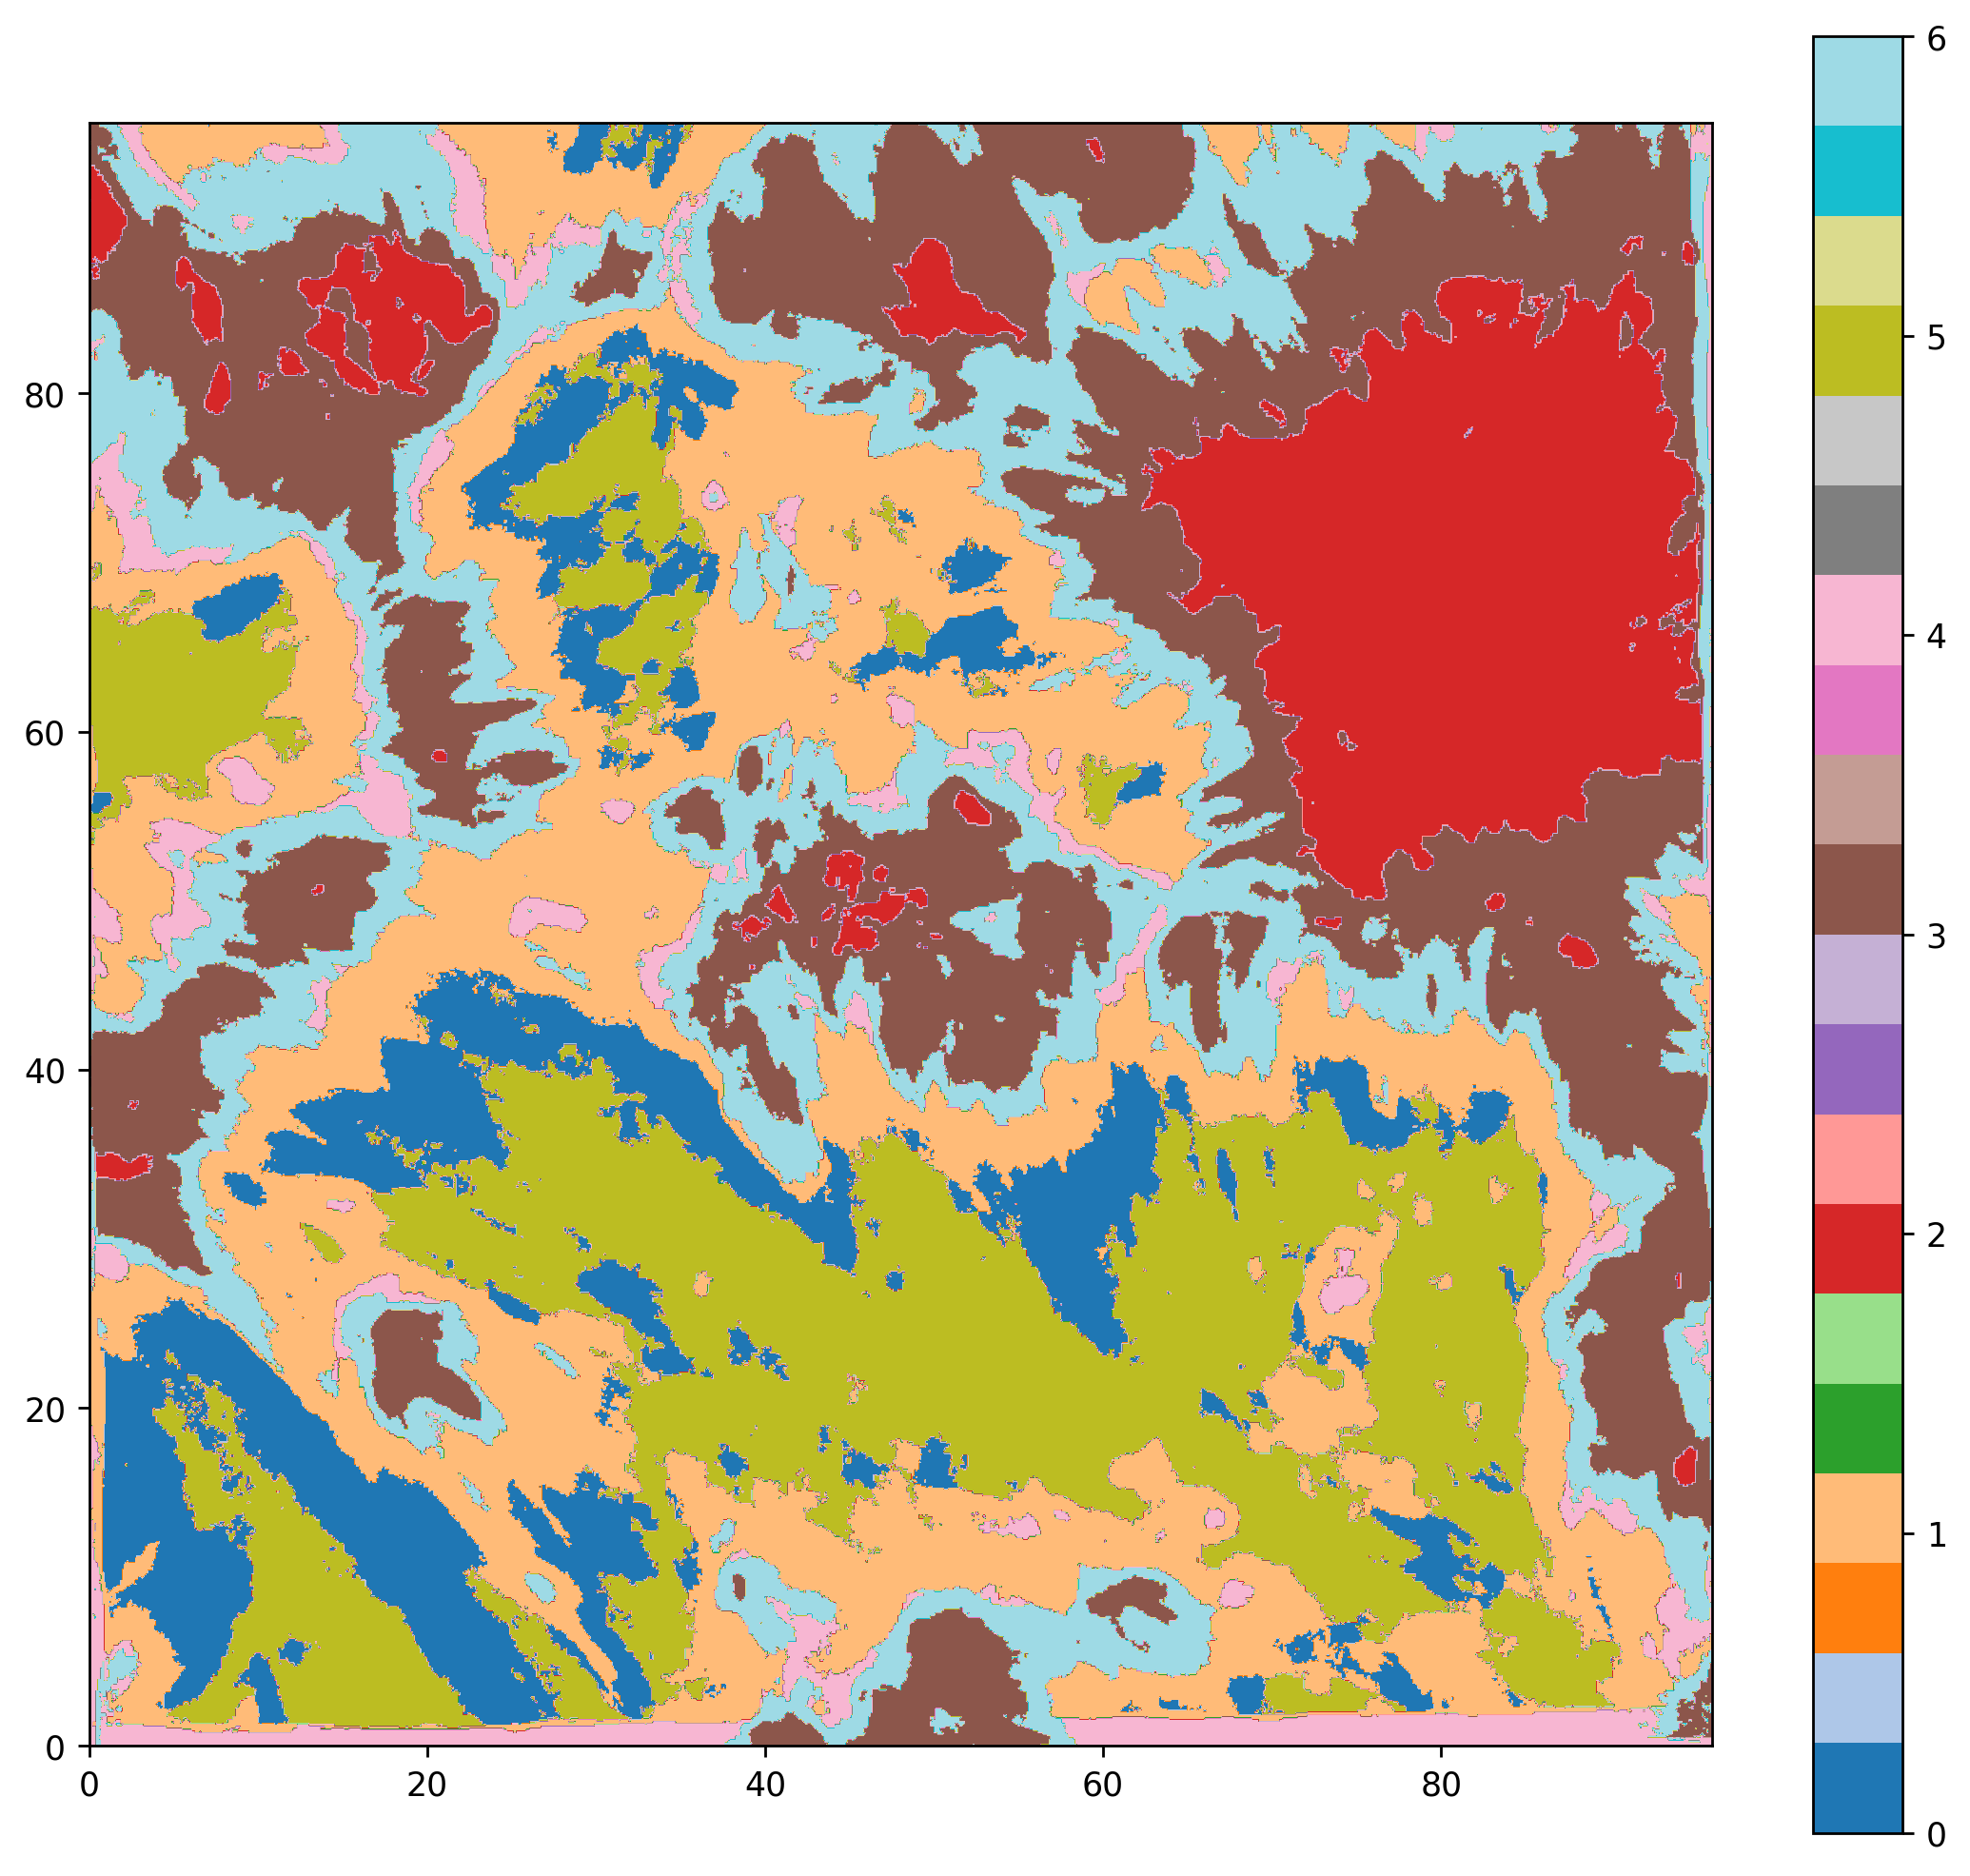

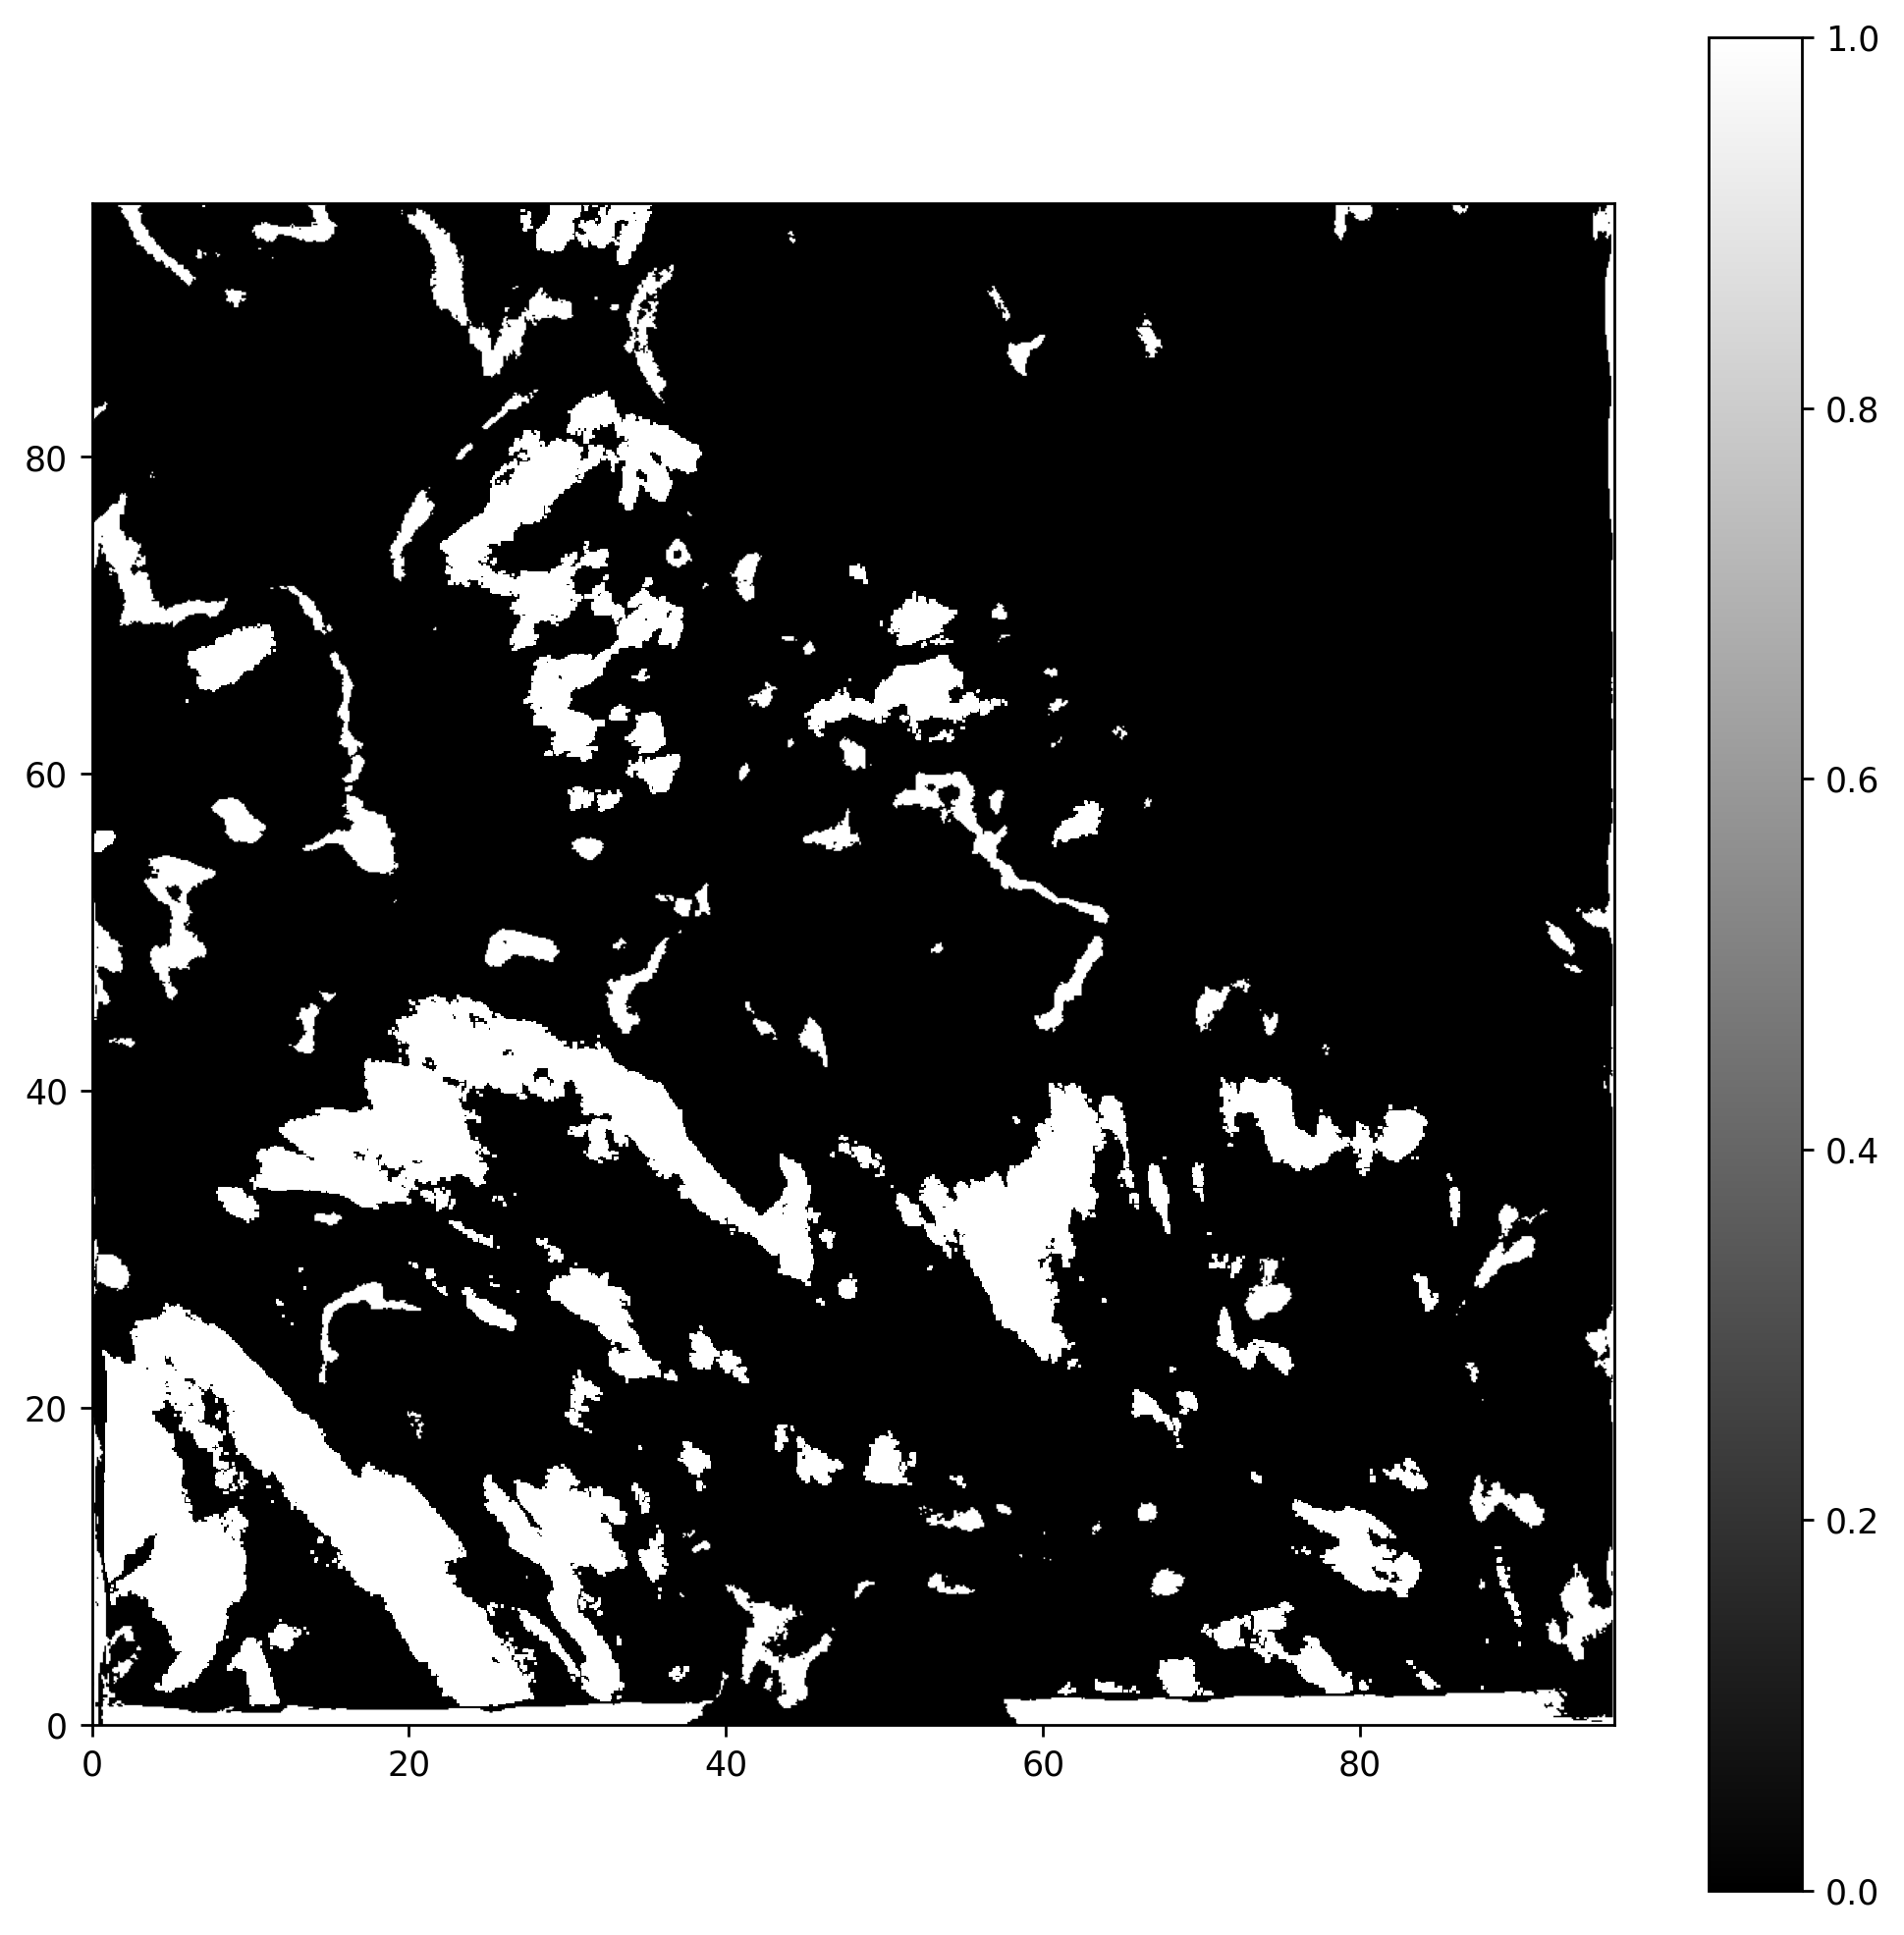

In [104]:
prediction = dpgmm.predict(data[:, 2:4])

pl.figure(dpi=250, figsize=(11, 10))
im0 = pl.imshow(prediction.reshape(1000, 1000), origin="lower", cmap="tab20",
                extent=extent)
pl.colorbar(im0)
pl.show()

masked_array = np.ma.masked_equal(prediction == 4, prediction)

pl.figure(figsize=(10, 10), dpi=250)
im1 = pl.imshow(masked_array.reshape(1000, 1000), origin="lower", cmap="gist_gray",
                extent=extent)
pl.colorbar(im1)
pl.show()

-- Smooth the boundaries with reducing/smoothing with a kernel? 

-- Look at the probability distributions in parameter space. 

-- Check out the coronal data? 

-- Add boundaries from masks

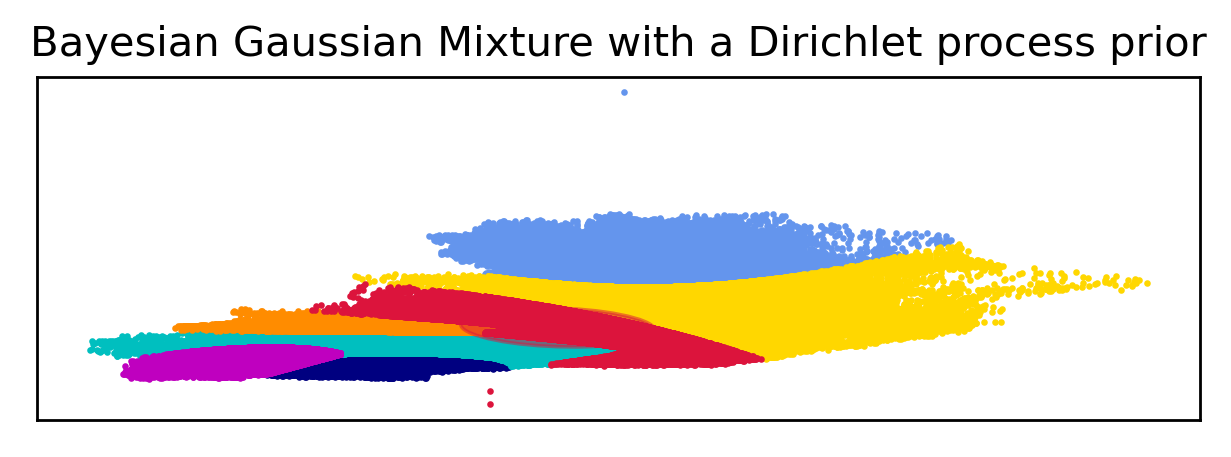

In [105]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl


color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange", 'm', "crimson", "lime"])

def plot_results(X, Y_, means, covariances, index, title):
    plt.figure(dpi=250)
    splot = plt.subplot(2, 1, 1 + index,)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        pl.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    pl.xticks(())
    pl.yticks(())
    pl.title(title)


plot_results(data[:, 2:4],
    dpgmm.predict(data[:, 2:4]),
    dpgmm.means_,
    dpgmm.covariances_,
    1,
    "Bayesian Gaussian Mixture with a Dirichlet process prior",
)